# Use Case Description
**CPU utilization forecasting** is a critical use case in IT operations and capacity planning, enabling organizations to proactively manage their infrastructure resources. By predicting future CPU usage patterns based on historical data and anticipated demand, businesses can optimize resource allocation, preventing both under-provisioning (which leads to performance bottlenecks and service degradation) and over-provisioning (which results in unnecessary infrastructure costs). This foresight allows for timely scaling decisions, whether it's adding or removing virtual machines, upgrading hardware, or adjusting cloud resource allocations, thereby ensuring consistent application performance, maintaining service level agreements (SLAs), and controlling operational expenses.

# Dataset
The **../sample_data/cpu_utilization.csv** dataset is used in this example, which is available under the data directory of this repo. The dataset contains 35,328 data points with 1-minute interval. It contains two fields: _time and cpu_util, showing the CPU utilization percentage over the monitoring period.

# Forecasting
In this example, we showcase how to use Cisco Time Series Model for CPU utilization forecasting based on historical trends. The historical data points on the time series are first processed into **multi-resolution** (1-minute interval for the latest 512 data points and 1-hour for the data points before), which is showcased in the notebook. With the multi-resolution input, the model forecasts the cpu_util value of the **next 128 timestamps**, which adds up to about 2 hours into the future.


# About this notebook
This notebook contains 6 stages to help users understand how to use the model:
* Stage 1: Import libraries and utilities
* Stage 2: Load the dataset and Visualize raw time series data
* Stage 3: Load the Cisco Time Series Model
* Stage 4: Visualization on the Multi-Resolution Processing
* Stage 5: Forecasting with Ground Truth
* Stage 6: Forecasting on Future States

---
# Stage 1: Import libraries and utilities

Libraries and functions for utilizing the model are imported in the cells below

In [1]:
import sys
from pathlib import Path

if "__file__" in globals():
    base_dir = Path(__file__).resolve().parent
else:
    base_dir = Path.cwd()

parent = base_dir.parent
if str(parent) not in sys.path:
	sys.path.insert(0, str(parent))
    
import pandas as pd
import torch
import matplotlib.pyplot as plt

from modeling import CiscoTsmMR, TimesFmHparams, TimesFmCheckpoint

 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.10 | packaged by conda-forge | (main, Oct 16 2024, 01:27:36) [GCC 13.3.0].


---
# Stage 2: Load the dataset and Visualize raw time series data

Read dataset from the data/ path and visualize the raw input time series

In [2]:
with open("../sample_data/cpu_utilization.csv", 'r') as f:
    df = pd.read_csv(f)
df['_time'] = pd.to_datetime(df['_time'], unit='s')
df = df.set_index('_time')
df

,cpu_util
_time,
2025-01-01 00:00:00,30.000000
2025-01-01 00:01:00,29.875000
2025-01-01 00:02:00,30.111111
2025-01-01 00:03:00,31.000000
2025-01-01 00:04:00,29.500000
...,...
2025-01-25 12:43:00,35.333332
2025-01-25 12:44:00,35.625000
2025-01-25 12:45:00,35.000000


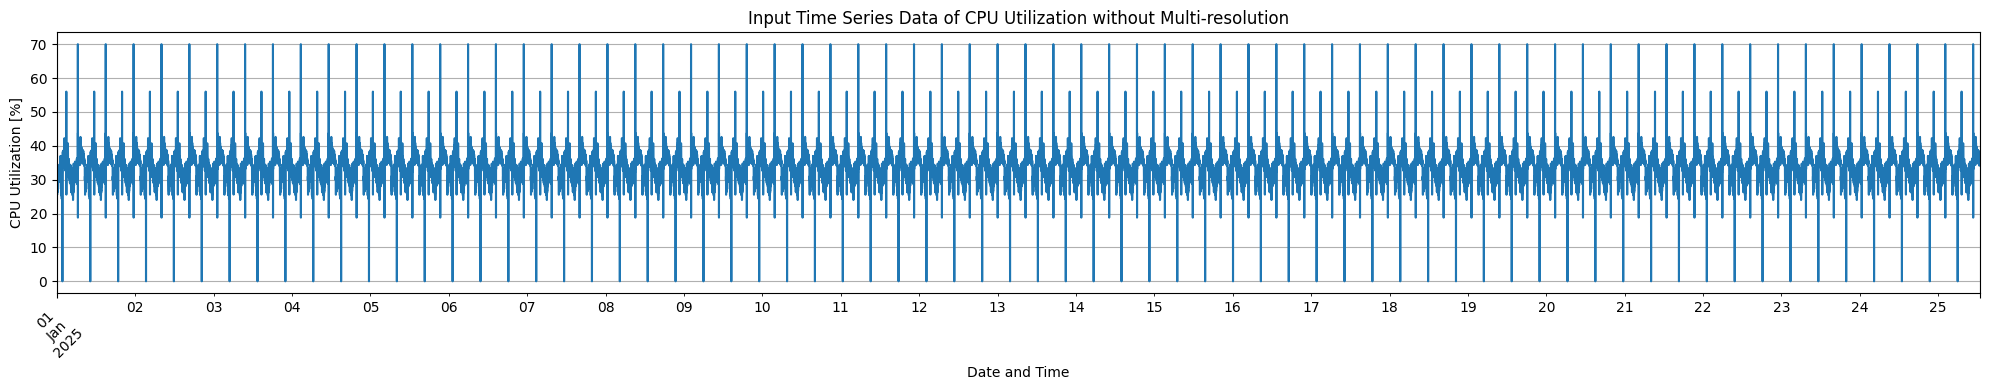

In [3]:
plt.figure(figsize=(20, 4))
df['cpu_util'].plot(title='Input Time Series Data of CPU Utilization without Multi-resolution', grid=True)
plt.xlabel('Date and Time')
plt.ylabel('CPU Utilization [%]')
plt.grid(True)
plt.xticks(rotation=45) 
plt.tight_layout() 
plt.show()

---
# Stage 3: Load the Cisco Time Series Model

Download the model checkpoint from Huggingface.

In [4]:
hp = TimesFmHparams(
	num_layers=50,
	use_positional_embedding=False,
	backend="gpu" if torch.cuda.is_available() else "cpu",
)

# Load model from the Huggingface repo of Cisco Time Series Model
repo_id = "cisco-ai/cisco-time-series-model-1.0-preview"

ckpt = TimesFmCheckpoint(huggingface_repo_id=repo_id)

model = CiscoTsmMR(
    hparams=hp,
    checkpoint=ckpt,
    use_resolution_embeddings=True,
    use_special_token=True,
)

Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

---
# [OPTIONAL] Stage 4: Visualization on the Multi-Resolution Processing 

* The cell below visualizes how multi-resolution processing transforms the input time series, This cell is **ONLY for showcasing purpose**. 
* During inference, the multi-reposution transformation happens automatically.

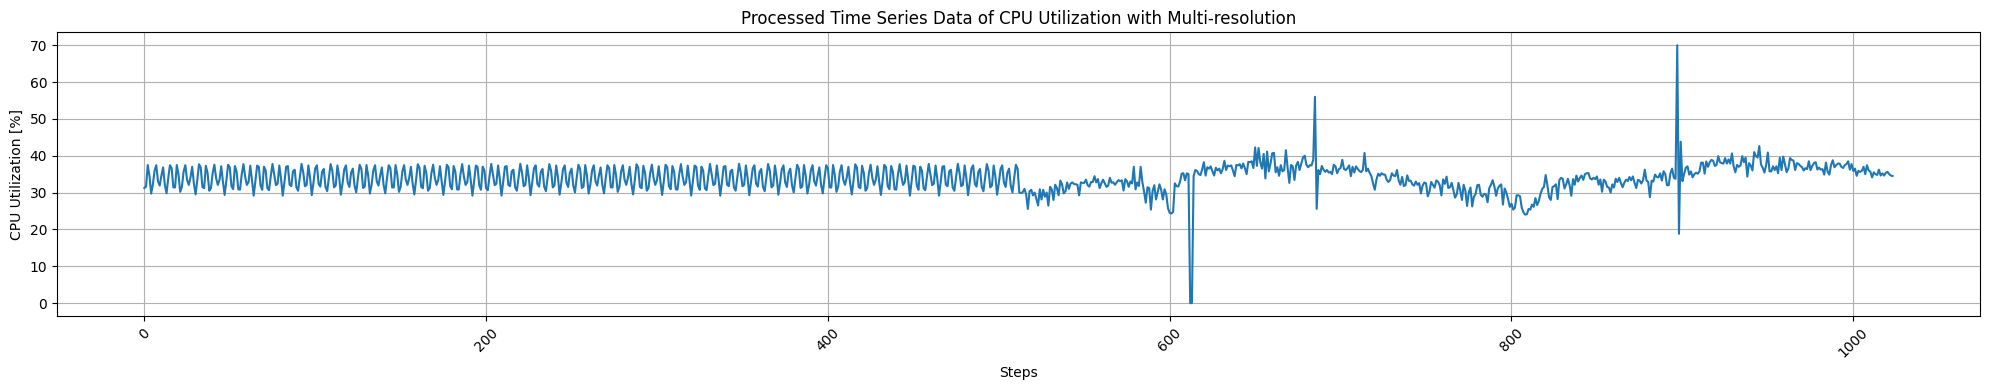

In [5]:
context_1hr, context_1min =  model.build_multi_resolution(df["cpu_util"].tolist())
processed_series = context_1hr
processed_series.extend(context_1min)
plt.figure(figsize=(20, 4))
plt.plot(list(range(len(processed_series))), processed_series, linestyle='-', markersize=4)
plt.title('Processed Time Series Data of CPU Utilization with Multi-resolution')
plt.xlabel('Steps')
plt.ylabel('CPU Utilization [%]')
plt.grid(True)
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

---
# Stage 5: Forecasting with Ground Truth

In order to showcase the model performance, we use the model to forecast the last 128 steps of the known time series and compare with the known values (ground truth) in the time series. 

In [6]:
FORECAST_WINDOW = 128

forecasts = model.forecast([df["cpu_util"].tolist()[:-FORECAST_WINDOW]], horizon_len=128)

/home/ubuntu/praneet/github/cisco-time-series-model/1.0-preview/modeling/cisco_tsm_mr.py:373: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  batch_coarse = torch.as_tensor(coarse_contexts[start:end],  dtype=torch.float32).unsqueeze(-1).to(self._device)


In [7]:
print("Mean: " + str(forecasts[0]["mean"].shape))
print("Quantile 0.1: " + str(forecasts[0]["quantiles"]["0.1"].shape))

Mean: (128,)
Quantile 0.1: (128,)


In [8]:
# Set ground-truth series for plot
ground_truth = processed_series.copy()
processed_input = processed_series[:-FORECAST_WINDOW]

# Obtain mean and quantiles of the forecasted series
means = processed_input + forecasts[0]["mean"].tolist()
p10 = processed_input + forecasts[0]["quantiles"]["0.1"].tolist() 
p20 = processed_input + forecasts[0]["quantiles"]["0.2"].tolist() 
p30 = processed_input + forecasts[0]["quantiles"]["0.3"].tolist() 
p40 = processed_input + forecasts[0]["quantiles"]["0.4"].tolist() 
p50 = processed_input + forecasts[0]["quantiles"]["0.5"].tolist() 
p60 = processed_input + forecasts[0]["quantiles"]["0.6"].tolist() 
p70 = processed_input + forecasts[0]["quantiles"]["0.7"].tolist() 
p80 = processed_input + forecasts[0]["quantiles"]["0.8"].tolist() 
p90 = processed_input + forecasts[0]["quantiles"]["0.9"].tolist() 

# Put all results into a dataframe
df_plot = pd.DataFrame({
    'Steps': list(range(len(ground_truth))),
    'Ground_Truth': ground_truth,
    'TSFM_Mean': means,
    'TSFM_P10': p10,
    'TSFM_P20': p20,
    'TSFM_P30': p30,
    'TSFM_P40': p40,
    'TSFM_P50': p50,
    'TSFM_P60': p60,
    'TSFM_P70': p70,
    'TSFM_P80': p80,
    'TSFM_P90': p90,
})

df_plot.set_index('Steps')

,Ground_Truth,TSFM_Mean,TSFM_P10,TSFM_P20,TSFM_P30,TSFM_P40,TSFM_P50,TSFM_P60,TSFM_P70,TSFM_P80,TSFM_P90
Steps,,,,,,,,,,,
0,31.258796,31.258796,31.258796,31.258796,31.258796,31.258796,31.258796,31.258796,31.258796,31.258796,31.258796
1,31.616832,31.616832,31.616832,31.616832,31.616832,31.616832,31.616832,31.616832,31.616832,31.616832,31.616832
2,37.476336,37.476336,37.476336,37.476336,37.476336,37.476336,37.476336,37.476336,37.476336,37.476336,37.476336
3,34.586806,34.586806,34.586806,34.586806,34.586806,34.586806,34.586806,34.586806,34.586806,34.586806,34.586806
4,29.736276,29.736276,29.736276,29.736276,29.736276,29.736276,29.736276,29.736276,29.736276,29.736276,29.736276
...,...,...,...,...,...,...,...,...,...,...,...
1019,35.333332,31.515179,28.287497,29.538734,30.398081,31.076927,31.666210,32.235012,32.854084,33.630417,34.909039
1020,35.625000,31.525183,28.209660,29.413801,30.273201,30.926056,31.517128,32.106308,32.754723,33.593708,34.897141
1021,35.000000,31.432423,28.160557,29.426762,30.254257,30.930454,31.520849,32.123959,32.750107,33.526459,34.812553


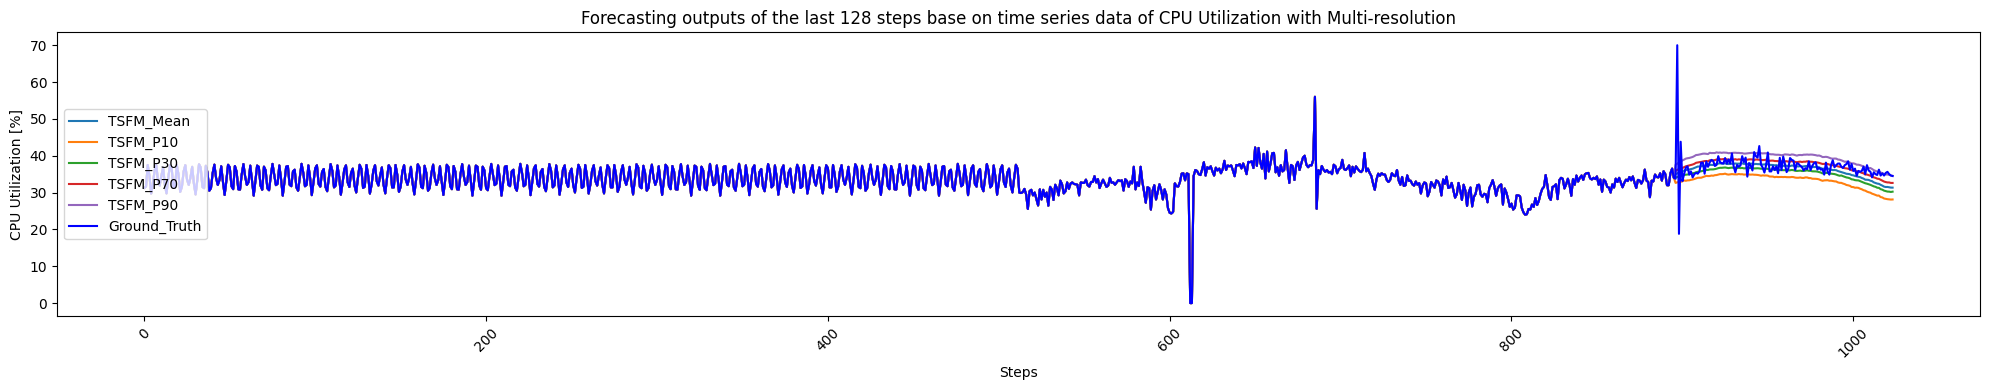

In [9]:
# Select columns to plot
df_plot_final = df_plot[['TSFM_Mean', 'TSFM_P10', 'TSFM_P30', 'TSFM_P70', 'TSFM_P90']]
plt.figure(figsize=(20, 4)) 
ax = df_plot_final.plot(ax=plt.gca(), title='Forecasting outputs of the last 128 steps base on time series data of CPU Utilization with Multi-resolution', grid=True)
# Add the plot of ground truth on the top
df_plot['Ground_Truth'].plot(ax=ax, color='blue', label='Ground_Truth')
plt.xlabel('Steps')
plt.ylabel('CPU Utilization [%]')
ax.legend(title='Data Series')
ax.legend(loc='center left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

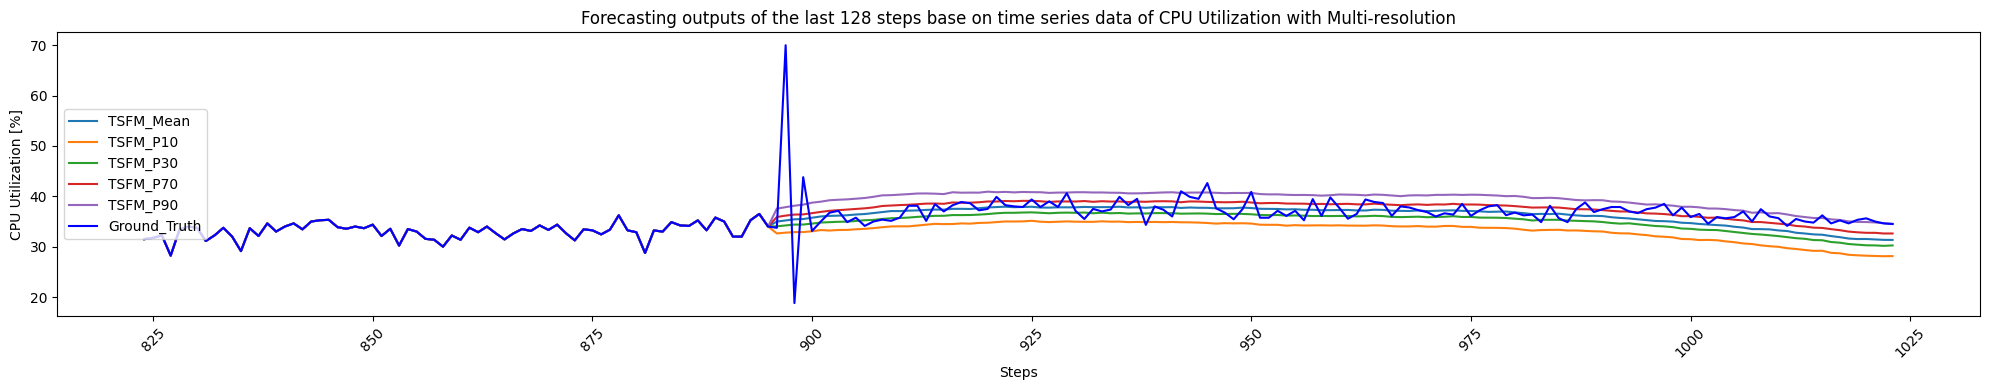

In [10]:
# Zoom in to the last 200 steps
df_plot_final = df_plot[['TSFM_Mean', 'TSFM_P10', 'TSFM_P30', 'TSFM_P70', 'TSFM_P90']][-200:]
plt.figure(figsize=(20, 4)) 
ax = df_plot_final.plot(ax=plt.gca(), title='Forecasting outputs of the last 128 steps base on time series data of CPU Utilization with Multi-resolution', grid=True)
# Add the plot of ground truth on the top
df_plot['Ground_Truth'][-200:].plot(ax=ax, color='blue', label='Ground_Truth')
plt.xlabel('Steps')
plt.ylabel('CPU Utilization [%]')
ax.legend(title='Data Series')
ax.legend(loc='center left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

---
# Stage 6: Forecasting on Future States

To forecast the future states, we use the model to forecast the next 128 steps into the future.

In [11]:
future_forecasts = model.forecast([df["cpu_util"].tolist()], horizon_len=128)

In [12]:
print("Mean: " + str(future_forecasts[0]["mean"].shape))
print("Quantile 0.1: " + str(future_forecasts[0]["quantiles"]["0.1"].shape))

Mean: (128,)
Quantile 0.1: (128,)


In [13]:
# Padding Ground-truth series
ground_truth_future = processed_series.copy()
ground_truth_future.extend(["N/A"]*128)

# Obtain mean and quantiles of the forecasted series
means_future = processed_series + future_forecasts[0]["mean"].tolist()
p10_future = processed_series + future_forecasts[0]["quantiles"]["0.1"].tolist() 
p20_future = processed_series + future_forecasts[0]["quantiles"]["0.2"].tolist() 
p30_future = processed_series + future_forecasts[0]["quantiles"]["0.3"].tolist() 
p40_future = processed_series + future_forecasts[0]["quantiles"]["0.4"].tolist() 
p50_future = processed_series + future_forecasts[0]["quantiles"]["0.5"].tolist() 
p60_future = processed_series + future_forecasts[0]["quantiles"]["0.6"].tolist() 
p70_future = processed_series + future_forecasts[0]["quantiles"]["0.7"].tolist() 
p80_future = processed_series + future_forecasts[0]["quantiles"]["0.8"].tolist() 
p90_future = processed_series + future_forecasts[0]["quantiles"]["0.9"].tolist() 

# Put all results into a dataframe
df_plot_future = pd.DataFrame({
    'Steps': list(range(len(ground_truth_future))),
    'Ground_Truth': ground_truth_future,
    'TSFM_Mean': means_future,
    'TSFM_P10': p10_future,
    'TSFM_P20': p20_future,
    'TSFM_P30': p30_future,
    'TSFM_P40': p40_future,
    'TSFM_P50': p50_future,
    'TSFM_P60': p60_future,
    'TSFM_P70': p70_future,
    'TSFM_P80': p80_future,
    'TSFM_P90': p90_future,
})

df_plot_future.set_index('Steps')

,Ground_Truth,TSFM_Mean,TSFM_P10,TSFM_P20,TSFM_P30,TSFM_P40,TSFM_P50,TSFM_P60,TSFM_P70,TSFM_P80,TSFM_P90
Steps,,,,,,,,,,,
0,31.258796,31.258796,31.258796,31.258796,31.258796,31.258796,31.258796,31.258796,31.258796,31.258796,31.258796
1,31.616832,31.616832,31.616832,31.616832,31.616832,31.616832,31.616832,31.616832,31.616832,31.616832,31.616832
2,37.476336,37.476336,37.476336,37.476336,37.476336,37.476336,37.476336,37.476336,37.476336,37.476336,37.476336
3,34.586806,34.586806,34.586806,34.586806,34.586806,34.586806,34.586806,34.586806,34.586806,34.586806,34.586806
4,29.736276,29.736276,29.736276,29.736276,29.736276,29.736276,29.736276,29.736276,29.736276,29.736276,29.736276
...,...,...,...,...,...,...,...,...,...,...,...
1147,N/A,33.060436,30.009390,31.425880,32.249279,32.836430,33.344528,33.835594,34.321423,34.890484,35.715885
1148,N/A,33.178471,30.133944,31.541082,32.344009,32.926655,33.427536,33.917610,34.393841,34.949558,35.766335
1149,N/A,33.319462,30.257101,31.653126,32.461533,33.056465,33.574112,34.066738,34.552711,35.106361,35.923901


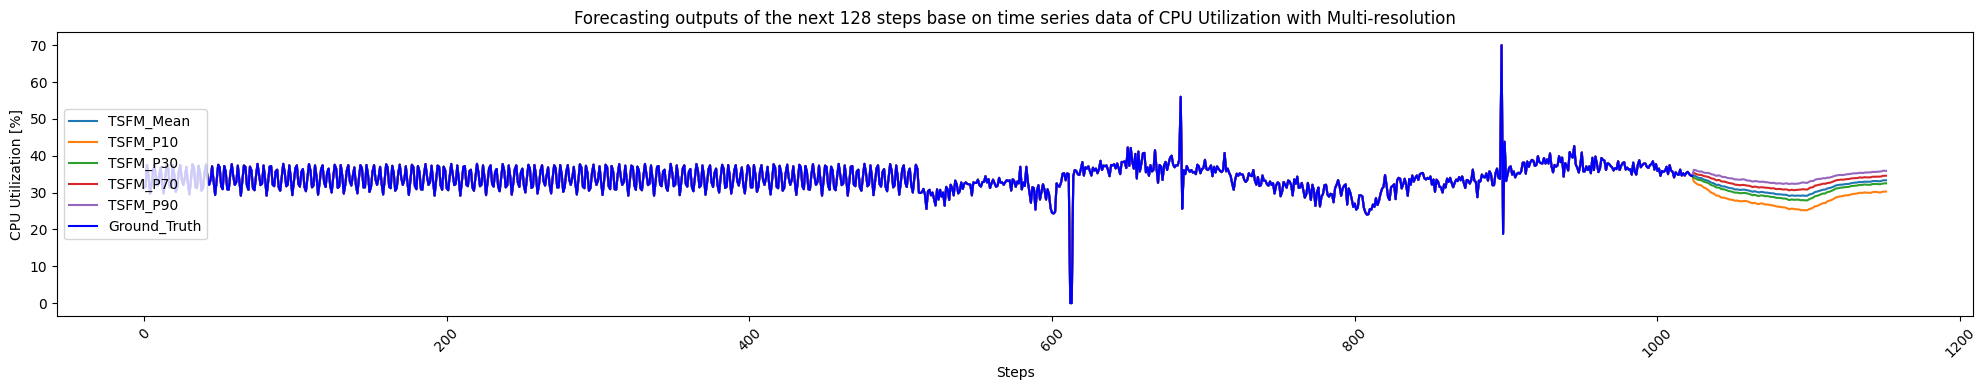

In [14]:
# Select columns to plot
df_plot_future_final = df_plot_future[['TSFM_Mean', 'TSFM_P10', 'TSFM_P30', 'TSFM_P70', 'TSFM_P90']]
plt.figure(figsize=(20, 4)) 
ax = df_plot_future_final.plot(ax=plt.gca(), title='Forecasting outputs of the next 128 steps base on time series data of CPU Utilization with Multi-resolution', grid=True)
# Add the plot of ground truth on the top
df_plot_future['Ground_Truth'][:-128].plot(ax=ax, color='blue', label='Ground_Truth')
plt.xlabel('Steps')
plt.ylabel('CPU Utilization [%]')
ax.legend(title='Data Series')
ax.legend(loc='center left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

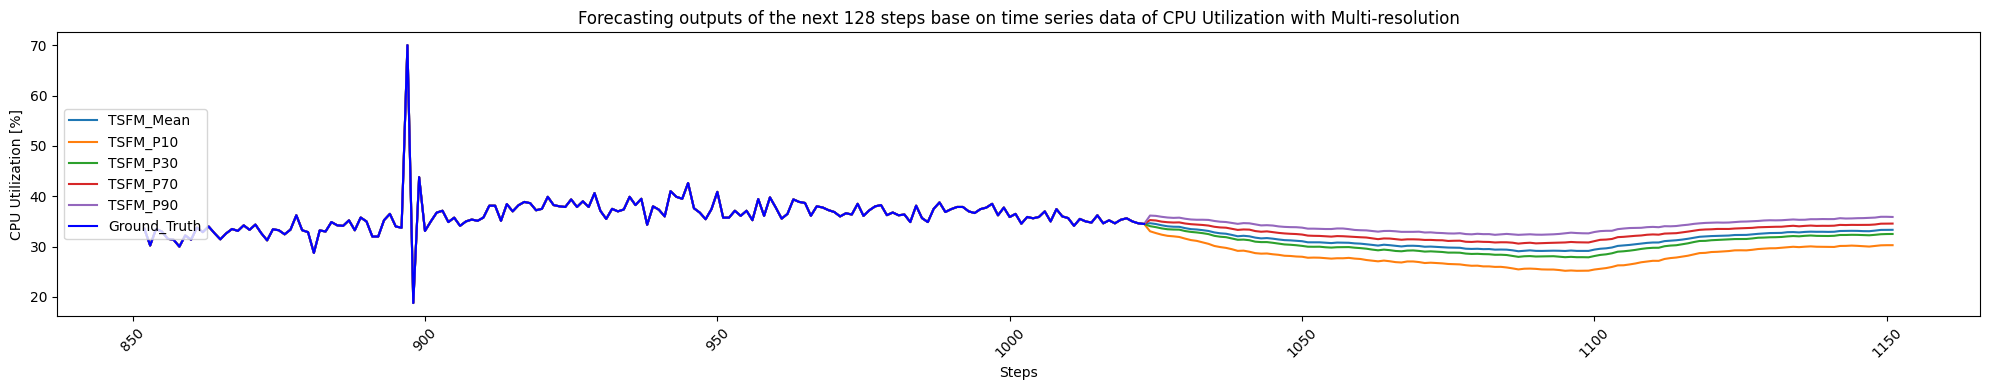

In [15]:
# Zoom in on the last 300 steps
df_plot_future_final = df_plot_future[['TSFM_Mean', 'TSFM_P10', 'TSFM_P30', 'TSFM_P70', 'TSFM_P90']][-300:]
plt.figure(figsize=(20, 4)) 
ax = df_plot_future_final.plot(ax=plt.gca(), title='Forecasting outputs of the next 128 steps base on time series data of CPU Utilization with Multi-resolution', grid=True)
# Add the plot of ground truth on the top
df_plot_future['Ground_Truth'][-300:][:-128].plot(ax=ax, color='blue', label='Ground_Truth')
plt.xlabel('Steps')
plt.ylabel('CPU Utilization [%]')
ax.legend(title='Data Series')
ax.legend(loc='center left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

---
# Notes on the model forcasting

It's important to note that forecasting models, especially when predicting future steps, inherently tend to produce a smoother curve. This characteristic means the model focuses on identifying and projecting the underlying patterns and general direction of the data, rather than attempting to replicate every minor fluctuation or "noise" present in the raw time series. This smoothing is a common and often desirable trait in forecasting, as it helps in understanding the broader trajectory and making strategic decisions, even if it doesn't perfectly mirror every instantaneous data point.
As shown in the forecasting results, compared to the ground truth, the model does not capture the sudden peaks. However, it successfully captures the majority of the series values within its interval between P10 and P90, providing a smooth and interpretable forecast. 
